In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta       
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10

2023-03-10 14:25:39.811060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Getting dataset from the files

In [66]:
(x_train0, y_train), (x_test0, y_test) = cifar10.load_data()
x_train, x_test = x_train0/255.0, x_test0/255.0
y_train = y_train.reshape(50000,)
y_test = y_test.reshape(10000,)
y_train.shape
x_train = x_train.reshape(-1, 3072)
x_test = x_test.reshape(-1, 3072)
x_train.shape

(50000, 3072)

Class distributionn


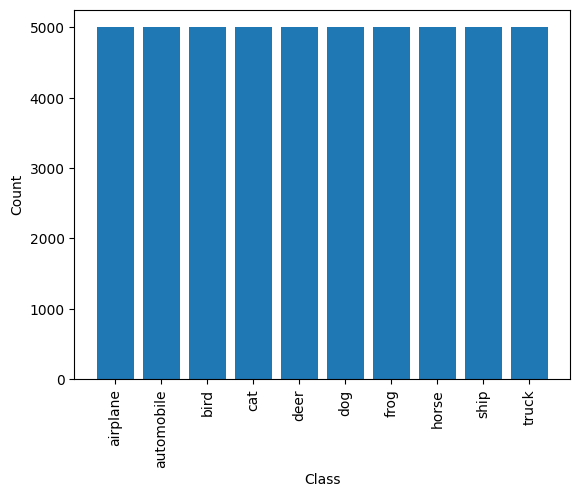

Understand pixel distribution (RGB Values)


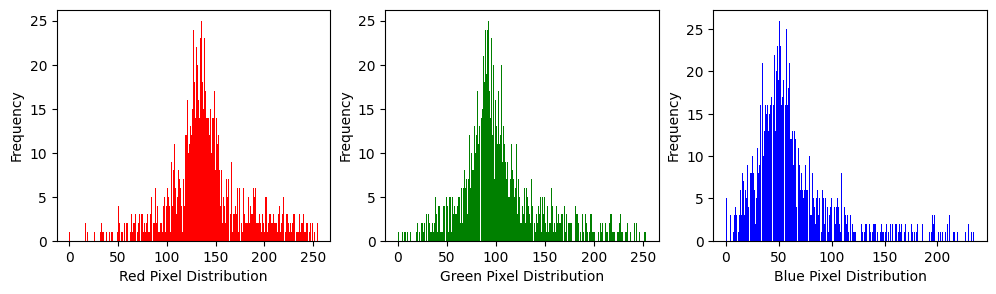

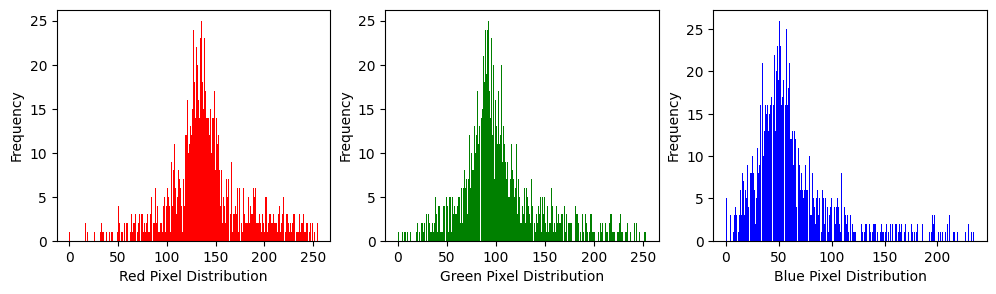

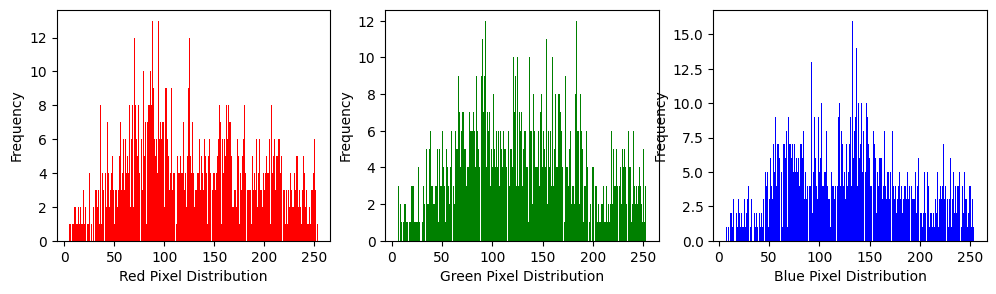

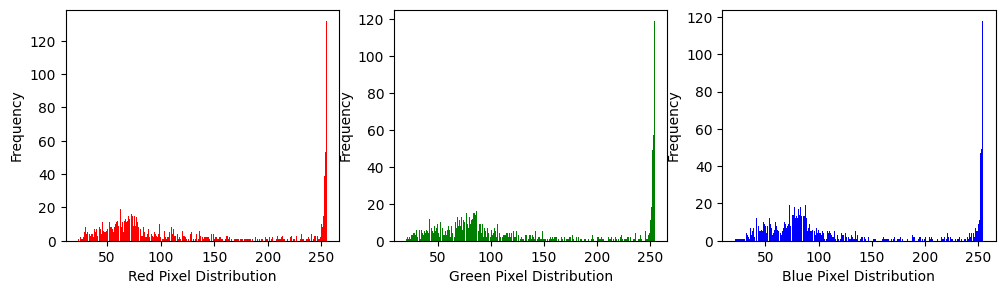

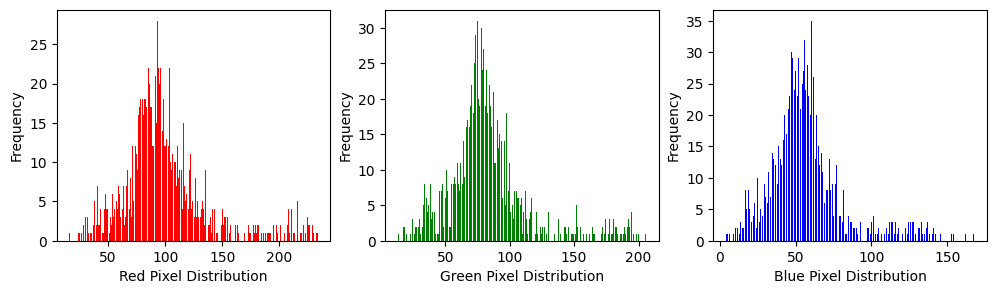

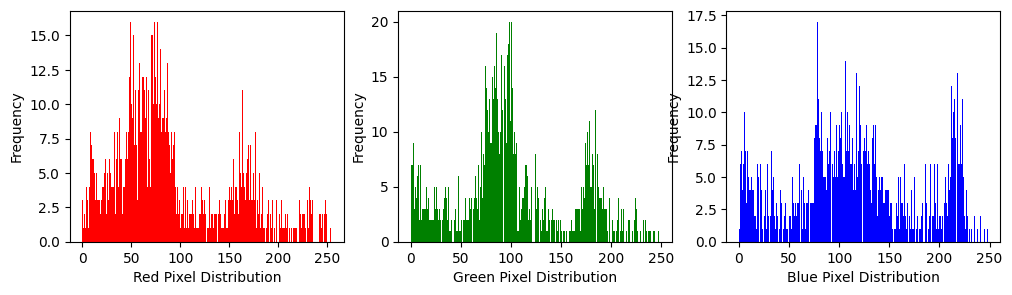

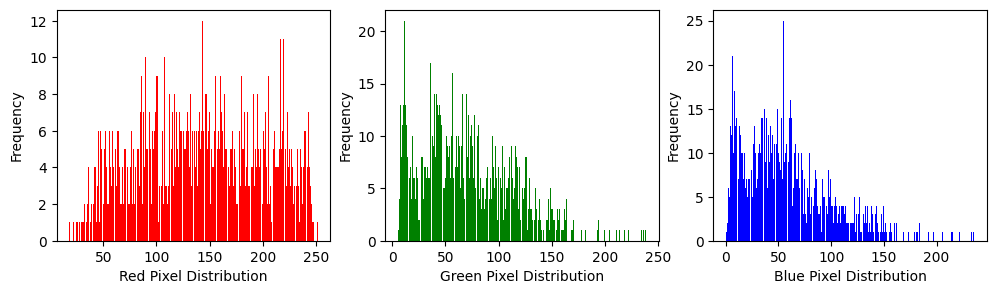

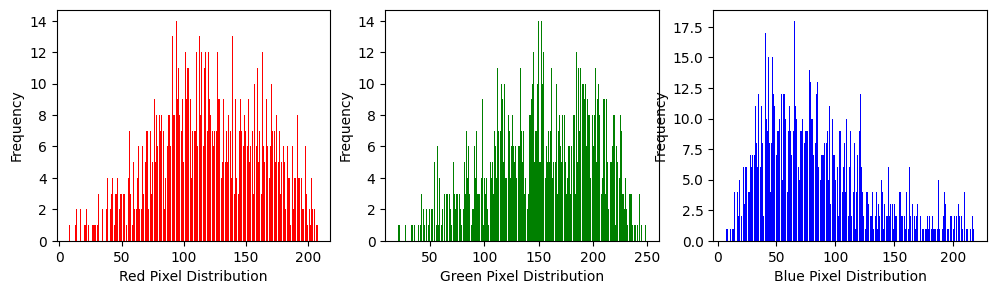

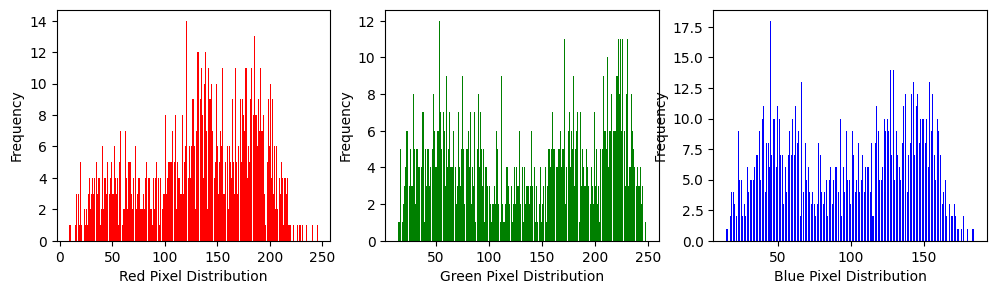

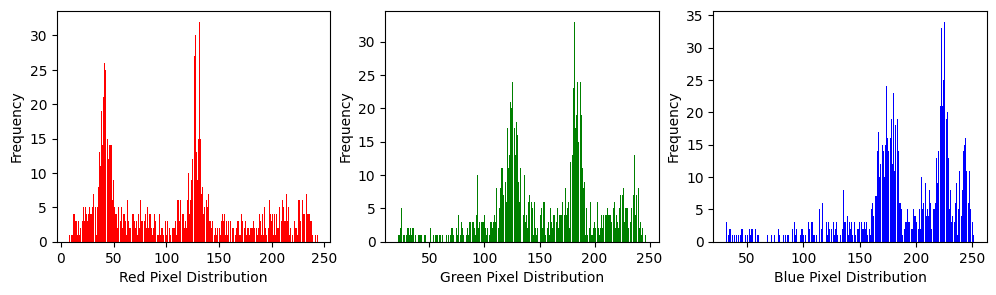

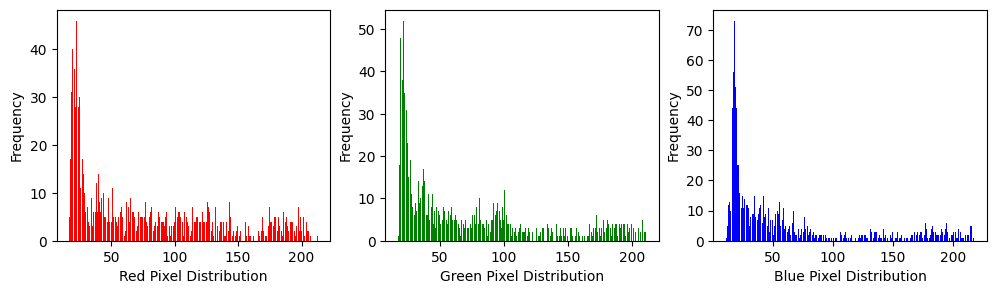

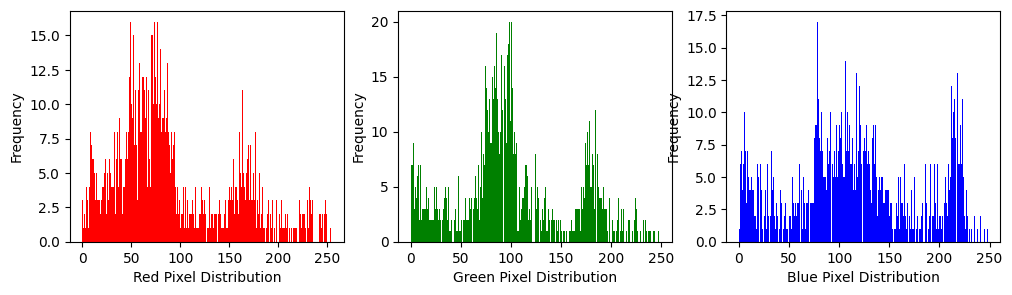

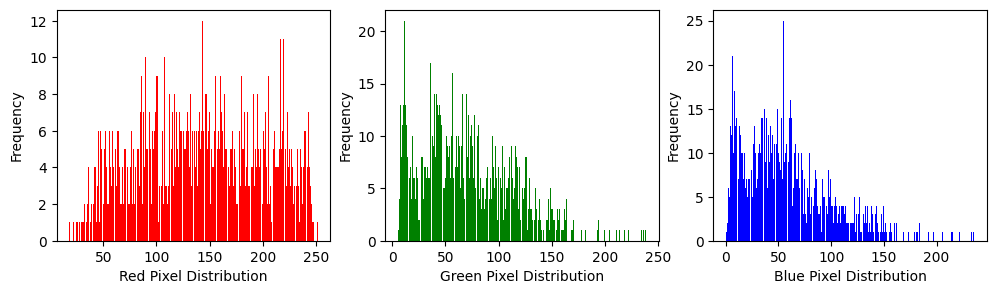

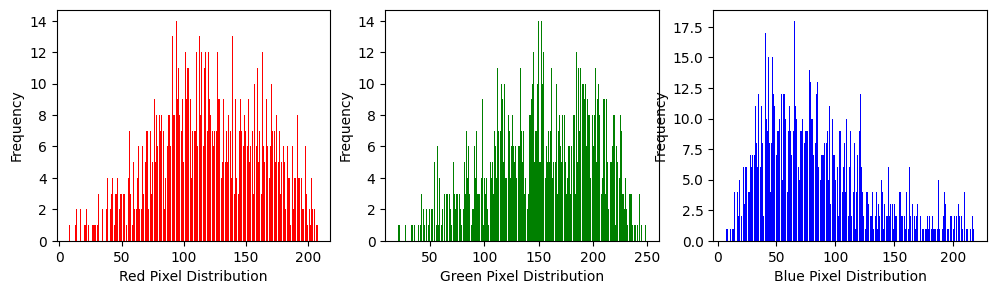

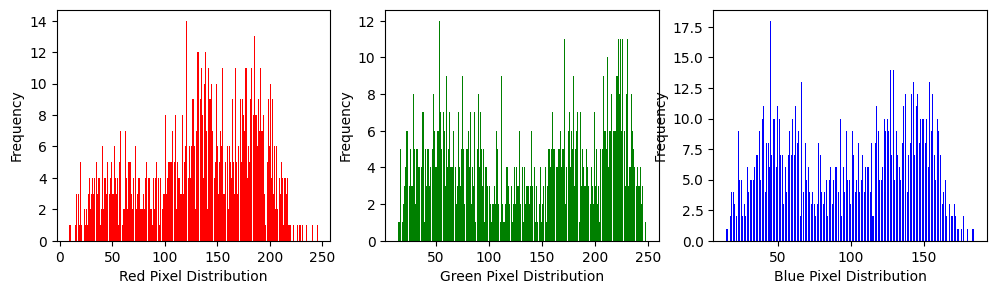

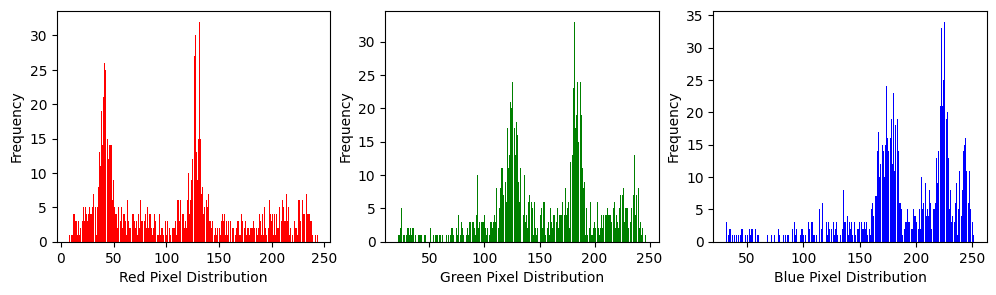

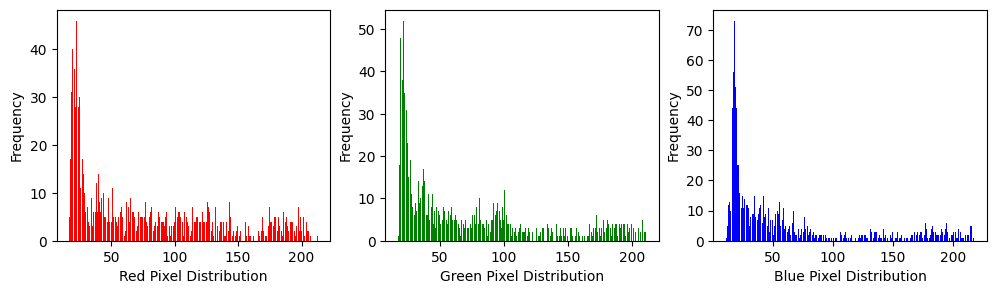

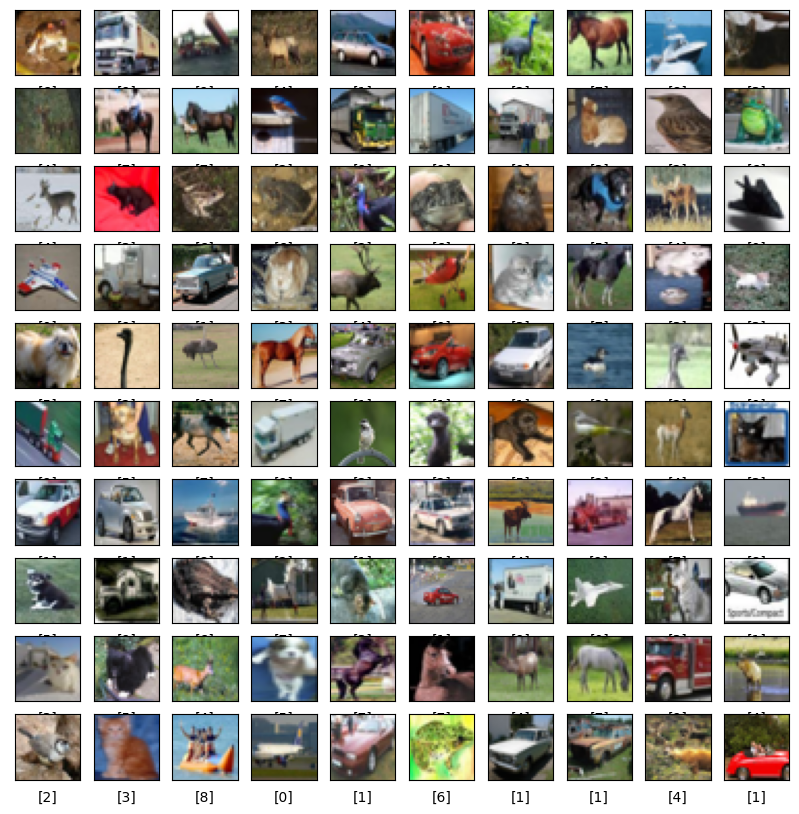

In [43]:
#Exploratory analysis to understand the data

(_, t_output), (_, _) = cifar10.load_data()

print("Class distributionn")

plt.bar(range(10), np.bincount(t_output.flatten()))
plt.xticks(range(10), ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], rotation=90)
plt.xlabel('Class')
plt.ylabel('Count')

plt.show()

(t_input, t_output), (_, _) = cifar10.load_data()

print("Understand pixel distribution (RGB Values)")

for a in range(10):
    _, axis = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

    axis[0].hist(t_input[a][:,:,0].ravel(), bins=256, color='red')
    axis[1].hist(t_input[a][:,:,1].ravel(), bins=256, color='green')
    axis[2].hist(t_input[a][:,:,2].ravel(), bins=256, color='blue')
    
    axis[0].set_xlabel("Red Pixel Distribution")
    axis[0].set_ylabel("Frequency")
    axis[1].set_xlabel("Green Pixel Distribution")
    axis[1].set_ylabel("Frequency")
    axis[2].set_xlabel("Blue Pixel Distribution")
    axis[2].set_ylabel("Frequency")

#First 100 images of dataset to get an idea of what our input data looks like
_, axis = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for i, a in enumerate(axis.flat):
    a.imshow(t_input[i])
    a.set(xticks=[], yticks=[], xlabel=t_output[i])
plt.show()

In [5]:

import numpy as np
class Relu:
    def activation(z):
      return np.maximum(0,z)
    def derivative(self,z):
        z[z<=0] = 0
        z[z>0] = 1
        return z

class Sigmoid:
    def activation(z):
        return 1 / (1 + np.exp(-z))
    def derivative(z):
        return Sigmoid.activation(z) * (1 - Sigmoid.activation(z))
    
def cost_derivative(aFunc, y):
    derivative = aFunc - y
    return derivative
def softmax(x):
    x = x - np.max(x, axis=1, keepdims=True)
    
    e = np.exp(x)
    
    s = np.sum(e, axis=1, keepdims=True)
    
    # handle division by zero or NaN
    s = np.where(np.isinf(s) | np.isnan(s), 1, s)
    
    return e / s
 

def softmax_derivative(z):
    return softmax(z)*softmax(1-z)

class leaky_relu:
    def activation(x, alpha = 0.01):
        return np.maximum(alpha * x, x)

    def prime(x, alpha = 0.01):
        dx = np.ones_like(x)
        dx[x < 0] = alpha
        return dx

class tanh:
    def activation(z):
	    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    def derivative(z):
      return 1 - np.power(tanh.activation(z), 2)

class Softmax:
    def activation(x):
      e = np.exp(x-np.max(x))
      s = np.sum(e, axis=1, keepdims=True)
      return e/s
    def derivative(z):
        return softmax.activation(z)*softmax.activation(1-z)

Multilayer perceptron algorithm:

In [71]:
class MLP:
    
    def __init__(self, aFunc, numOfHiddenLayers, dimension):
        self.aFunc = aFunc
        self.numOfHiddenLayers = numOfHiddenLayers
        self.dimension = dimension
        self.weights = {}
        self.biases = {}
        self.aFunc = {}
        for i in range(len(self.dimension)-1):
            self.weights[i + 1] = np.random.randn(dimension[i], dimension[i + 1])/ np.sqrt(dimension[i])
            self.biases[i + 1] = np.zeros(dimension[i + 1])
            self.aFunc[i + 2] = aFunc[i]
            
    def fit(self, x, y, optimizer):
        
        def backprop(self, Mlp, x, y):
            z = {}
            a = {1: x}  
            
            for i in range(1, len(Mlp.dimension)):
                z[i + 1] = np.dot(a[i], Mlp.weights[i]) + Mlp.biases[i]
                a[i + 1] = Mlp.aFunc[i+1].activation(z[i + 1])
            last = len(a)
            delta = cost_derivative(a[last], y) * softmax_derivative(a[last]) 
            dw = np.dot(a[len(Mlp.dimension) - 1].T, delta)
        
            update_params = {
                 len(Mlp.dimension) - 1: (dw, delta)
            }

            for i in reversed(range(2, len(Mlp.dimension))):
                dr = Mlp.aFunc[i].derivative(z[i]) 
                delta = np.dot(delta, Mlp.weights[i].T) * dr
                dw = np.dot(a[i - 1].T, delta)
                update_params[i - 1] = (dw, delta)

            return update_params


        self, accuracy_list = optimizer.run(self,backprop, x, y)
        return self, accuracy_list
            
    def predict(self, x):
        z = {}
        a = {1: x}  
        
        for i in range(1, len(self.dimension)):
            z[i + 1] = np.dot(a[i], self.weights[i]) + self.biases[i]
            a[i + 1] = self.aFunc[i+1].activation(z[i + 1])
        return np.argmax(a[len(self.dimension)],axis=1)

GradientDescent Algorithm

In [69]:
class GradientDescent:
    
    def __init__(self, learning_rate=1e-3, batch_size=64, max_iters=200, epsilon=1e-8, numOfHiddenLayers=0, lam = 0, regularization = None):
        self.numOfHiddenLayers = numOfHiddenLayers
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.lam = lam
        self.regularization = regularization
        
    def run(self, mlp,gradient_fn, x, y):
        accuracy_list = []
        m = x.shape
        num_batches = m[0] // self.batch_size
        norms = np.array([np.inf])
        t = 0
        while t < self.max_iters:
            # Shuffle the data
            seed = np.arange(x.shape[0])
            np.random.shuffle(seed)
            x_shuffle = x[seed]
            y_shuffle = y[seed]
            
            for j in range(x.shape[0] // self.batch_size):
                k = j * self.batch_size
                l = (j + 1) * self.batch_size
                x_batch = x_shuffle[k:l]
                y_batch = y_shuffle[k:l]

                # Compute the gradient 
                grad = gradient_fn(self,mlp,x_batch, y_batch)
                for k, v in grad.items():
                    dw = v[0]
                    if self.regularization == "l2":
                        dw += (self.lam) * np.square(mlp.weights[k])
                    elif self.regularization == "l1":
                        dw += (self.lam) * np.abs(mlp.weights[k])
                    mlp.weights[k] -= self.learning_rate * dw
                    mlp.biases[k] -= self.learning_rate * np.mean(v[1], 0)
            t += 1
            accuracy_list.append(np.mean(mlp.predict(x_test) == np.argmax(y_test,axis = 1)))
        return mlp, accuracy_list

Experiment 1: 
First of all, create three different models: (1) an MLP with no hidden layers, i.e., it directly maps the inputs
to outputs, (2) an MLP with a single hidden layer having 256 units and ReLU activations, (3) an MLP with 2
hidden layers each having 256 units with ReLU activations. It should be noted that since we want to perform
classification, all of these models should have a softmax layer at the end. After training, compare the test
accuracy of these three models on the CIFAR-10 dataset. Comment on how non-linearity and network depth
affects the accuracy. Are the results that you obtain expected?

In [72]:

y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

In [56]:
# #two layers
optimizer = GradientDescent()
double_layer=  MLP((Relu, Relu, Softmax,),numOfHiddenLayers=2,dimension=(3072,256,256,10))
fit_double_layer, a_2 = double_layer.fit(x_train,y_train, optimizer)
print("Accuracy on test data two layers", np.mean(fit_double_layer.predict(x_test) == np.argmax(y_test,axis = 1)))

Accuracy on test data two layers 0.5069


Accuracy on test data no layer 0.4018
Accuracy on test data one layer 0.4879


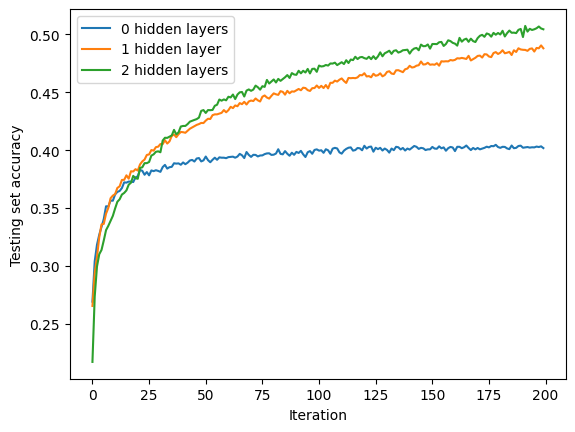

In [53]:
# #no hidden layers
no_hidden = MLP((Softmax,),numOfHiddenLayers=0,dimension=(3072,10))
optimizer = GradientDescent()
fit_no_hidden, a_0 = no_hidden.fit(x_train,y_train, optimizer)
print("Accuracy on test data no layer", np.mean(fit_no_hidden.predict(x_test) == np.argmax(y_test,axis = 1)))

#one layer
optimizer = GradientDescent()
single_layer=  MLP((Relu, Softmax,),numOfHiddenLayers=1,dimension=(3072,256,10))
fit_single_layer, a_1 = single_layer.fit(x_train,y_train, optimizer)
print("Accuracy on test data one layer", np.mean(fit_single_layer.predict(x_test) == np.argmax(y_test,axis = 1)))


# Create a line plot of the accuracies for each list
plt.plot(a_0, label='0 hidden layers')
plt.plot(a_1, label='1 hidden layer')
plt.plot(a_2, label='2 hidden layers')

# Add labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Testing set accuracy')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()


Experiment 2:
 Take the last model above, the one with 2 hidden layers, and create two different copies of it in which the
activations are now tanh and Leaky-ReLU. After training these two models compare their test accuracies with
model having ReLU activations. Comment on the performances of these models: which one is better and why?
Are certain activations better than others? If the results are not as you expected, what could be the reason?

In [ ]:
optimizer = GradientDescent(numOfHiddenLayers=2)
#TANH
two_tanh = MLP((tanh, tanh, Softmax,),numOfHiddenLayers=2,dimension=(3072,256,256,10))
fit_two_tanh, a_3 = two_tanh.fit(x_train,y_train, optimizer)
print("Accuracy on test data tanh", np.mean(fit_two_tanh.predict(x_test) == np.argmax(y_test,axis = 1)))


Accuracy on test data tanh 0.49


In [ ]:
#Leaky-Relu
optimizer = GradientDescent(numOfHiddenLayers=2)
two_lrelu= MLP((leaky_relu, leaky_relu, Softmax,),numOfHiddenLayers=2,dimension=(3072,256,256,10))
fit_two_lrelu, a_4 = two_lrelu.fit(x_train,y_train, optimizer)
print("Accuracy on test data leaky-relu", np.mean(fit_two_lrelu.predict(x_test) == np.argmax(y_test,axis = 1)))

Accuracy on test data leaky-relu 0.5024


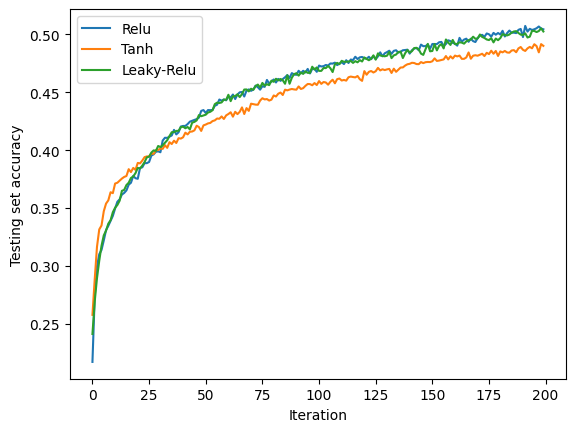

In [ ]:
# Create a line plot of the accuracies for each list
plt.plot(a_2, label='Relu')
plt.plot(a_3, label='Tanh')
plt.plot(a_4, label='Leaky-Relu')

# Add labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Testing set accuracy')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

Experiment 3:
Create an MLP with 2 hidden layers each having 256 units with ReLU activations as above. However, this
time, independently add L1 and L2 regularization to the network and train the MLP in this way. How does
these regularizations affect the accuracy? This proportion can be varied as a tunable hyperparameter that can be
explored as part of other project requirements.

In [ ]:
#L1 regularization
optimizer = GradientDescent(numOfHiddenLayers=2, lam = 0.01, regularization="l1")
double_layer_l1=  MLP((Relu, Relu, Softmax,),numOfHiddenLayers=2,dimension=(3072,256,256,10))
fit_two_layers_l1, a_5 = double_layer_l1.fit(x_train,y_train, optimizer)
print("Accuracy on test data with l1 regularization", np.mean(fit_two_layers_l1.predict(x_test) == np.argmax(y_test,axis = 1)))
#L2 Regularization
optimizer = GradientDescent(numOfHiddenLayers=2, lam = 0.01, regularization="l2")
double_layer_l2=  MLP((Relu, Relu, Softmax,),numOfHiddenLayers=2,dimension=(3072,256,256,10))
fit_two_layers_l2, a_6= double_layer_l2.fit(x_train,y_train, optimizer)
print("Accuracy on test data with l2 regularization", np.mean(fit_two_layers_l2.predict(x_test) == np.argmax(y_test,axis = 1)))


Accuracy on test data with l1 regularization 0.4774
Accuracy on test data with l2 regularization 0.509


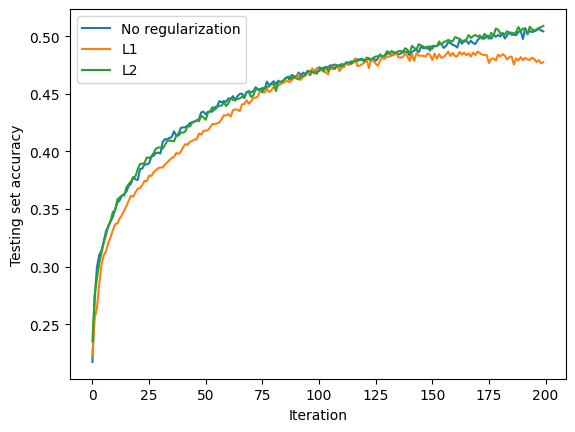

In [ ]:
# Create a line plot of the accuracies for each list
plt.plot(a_2, label='No regularization')
plt.plot(a_5, label='L1')
plt.plot(a_6, label='L2')

# Add labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Testing set accuracy')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

Experiment 4:
Create an MLP with 2 hidden layers each having 256 units with ReLU activations as above. However, this time,
train it with unnormalized images. How does this affect the accuracy?

In [73]:
x_train0 = x_train.reshape(-1, 3072)
x_test0 = x_test.reshape(-1, 3072)
optimizer_u = GradientDescent(numOfHiddenLayers=2)
two_layers_u = MLP((Relu, Relu, Softmax,),numOfHiddenLayers=2,dimension=(3072,256,256,10))
two_relu_u, u_accuracy = two_layers_u.fit(x_train0,y_train, optimizer_u)
print("Accuracy on test data without normalization", np.mean(two_relu_u.predict(x_test0) == np.argmax(y_test,axis = 1)))

Accuracy on test data without normalization 0.5059


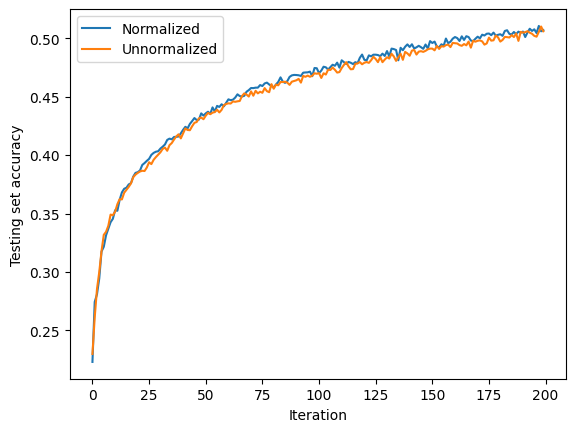

In [74]:
# Create a line plot of the accuracies for each list
plt.plot(a_2, label='Normalized')
plt.plot(u_accuracy, label='Unnormalized')

# Add labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Testing set accuracy')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

Experiment 5:
Using existing libraries such as TensorFlow or PyTorch, create a convolutional neural network (CNN) with 2
convolutional and 2 fully connected layers. Although you are free in your choice of the hyperparameters of the
convolutional layers, set the number of units in the fully connected layers to be 256. Also, set the activations in
all of the layers to be ReLU. Train this CNN on the CIFAR-10 dataset. Does using a CNN increase/decrease the
accuracy compared to using MLPs? Provide comments on your results.

In [ ]:
# How well does a CNN do with SGD :
#https://www.tensorflow.org/tutorials/images/cnn

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import cifar10
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical

# Define the hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.01

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the CNN
cnn_model = Sequential()
cnn_model.add(Conv2D(32, 4, activation="relu", input_shape=(32, 32, 3)))
cnn_model.add(MaxPooling2D())
cnn_model.add(Conv2D(64, 4, activation="relu"))
cnn_model.add(MaxPooling2D())
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dense(10))

cnn_model.compile(optimizer=SGD(learning_rate),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
# Train the model
cnn_history  = cnn_model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test accuracy:", test_acc)

2023-03-10 17:37:38.935931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
782/782 [==============================] - 38s 48ms/step - loss: 2.1311 - accuracy: 0.2205 - val_loss: 2.0602 - val_accuracy: 0.2259
Epoch 2/10
782/782 [==============================] - 43s 55ms/step - loss: 1.8475 - accuracy: 0.3370 - val_loss: 1.7954 - val_accuracy: 0.3592
Epoch 3/10
782/782 [==============================] - 37s 48ms/step - loss: 1.6551 - accuracy: 0.4086 - val_loss: 1.6991 - val_accuracy: 0.3991
Epoch 4/10
782/782 [==============================] - 43s 55ms/step - loss: 1.5321 - accuracy: 0.4516 - val_loss: 1.6482 - val_accuracy: 0.3966
Epoch 5/10
782/782 [==============================] - 36s 45ms/step - loss: 1.4497 - accuracy: 0.4834 - val_loss: 1.4554 - val_accuracy: 0.4707
Epoch 6/10
782/782 [==============================] - 34s 44ms/step - loss: 1.3870 - accuracy: 0.5063 - val_loss: 1.3708 - val_accuracy: 0.5016
Epoch 7/10
782/782 [==============================] - 34s 44ms/step - loss: 1.3311 - accuracy: 0.5268 - val_loss: 1.6215 - val_accuracy:

In [ ]:
# What if we change batch size for SGD?
#https://www.tensorflow.org/tutorials/images/cnn

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import cifar10
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical

# Define the hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.01

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the CNN
cnn_model = Sequential()
cnn_model.add(Conv2D(32, 4, activation="relu", input_shape=(32, 32, 3)))
cnn_model.add(MaxPooling2D())
cnn_model.add(Conv2D(64, 4, activation="relu"))
cnn_model.add(MaxPooling2D())
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dense(10))

cnn_model.compile(optimizer=SGD(learning_rate),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
# Train the model
cnn_history  = cnn_model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test accuracy:", test_acc)

Epoch 1/10
391/391 [==============================] - 37s 93ms/step - loss: 2.2094 - accuracy: 0.1811 - val_loss: 2.0518 - val_accuracy: 0.2533
Epoch 2/10
391/391 [==============================] - 43s 109ms/step - loss: 1.9814 - accuracy: 0.2786 - val_loss: 1.9433 - val_accuracy: 0.2915
Epoch 3/10
391/391 [==============================] - 41s 104ms/step - loss: 1.8651 - accuracy: 0.3320 - val_loss: 1.8109 - val_accuracy: 0.3457
Epoch 4/10
391/391 [==============================] - 34s 87ms/step - loss: 1.7651 - accuracy: 0.3699 - val_loss: 1.6816 - val_accuracy: 0.3954
Epoch 5/10
391/391 [==============================] - 31s 80ms/step - loss: 1.6594 - accuracy: 0.4042 - val_loss: 1.6221 - val_accuracy: 0.4178
Epoch 6/10
391/391 [==============================] - 32s 82ms/step - loss: 1.5835 - accuracy: 0.4302 - val_loss: 1.8476 - val_accuracy: 0.3602
Epoch 7/10
391/391 [==============================] - 31s 79ms/step - loss: 1.5259 - accuracy: 0.4522 - val_loss: 1.5312 - val_accurac

In [ ]:
# What if we change learning rate for SGD?
#https://www.tensorflow.org/tutorials/images/cnn

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import cifar10
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical

# Define the hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.1

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the CNN
cnn_model = Sequential()
cnn_model.add(Conv2D(32, 4, activation="relu", input_shape=(32, 32, 3)))
cnn_model.add(MaxPooling2D())
cnn_model.add(Conv2D(64, 4, activation="relu"))
cnn_model.add(MaxPooling2D())
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dense(10))

cnn_model.compile(optimizer=SGD(learning_rate),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
# Train the model
cnn_history  = cnn_model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test accuracy:", test_acc)

Epoch 1/10
782/782 [==============================] - 37s 43ms/step - loss: 1.8843 - accuracy: 0.3181 - val_loss: 2.4327 - val_accuracy: 0.2325
Epoch 2/10
782/782 [==============================] - 34s 43ms/step - loss: 1.4058 - accuracy: 0.4971 - val_loss: 1.4971 - val_accuracy: 0.4679
Epoch 3/10
782/782 [==============================] - 35s 44ms/step - loss: 1.1926 - accuracy: 0.5767 - val_loss: 1.1780 - val_accuracy: 0.5786
Epoch 4/10
782/782 [==============================] - 35s 44ms/step - loss: 1.0399 - accuracy: 0.6330 - val_loss: 1.1821 - val_accuracy: 0.5989
Epoch 5/10
782/782 [==============================] - 35s 45ms/step - loss: 0.9188 - accuracy: 0.6772 - val_loss: 1.6064 - val_accuracy: 0.4758
Epoch 6/10
782/782 [==============================] - 34s 44ms/step - loss: 0.8054 - accuracy: 0.7174 - val_loss: 1.2208 - val_accuracy: 0.6012
Epoch 7/10
782/782 [==============================] - 35s 44ms/step - loss: 0.7019 - accuracy: 0.7550 - val_loss: 1.0789 - val_accuracy:

In [ ]:
# How well does a CNN with Adam perform
#https://www.tensorflow.org/tutorials/images/cnn

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import cifar10
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical

# Define the hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.001

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the CNN
cnn_model = Sequential()
cnn_model.add(Conv2D(32, 4, padding = "same", activation="relu", input_shape=(32, 32, 3)))
cnn_model.add(MaxPooling2D())
cnn_model.add(Conv2D(64, 4, padding = "same", activation="relu"))
cnn_model.add(MaxPooling2D())
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dense(10))

#Compile the model
cnn_model.compile(optimizer=Adam(learning_rate),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
# Train the model
cnn_history  = cnn_model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test accuracy:", test_acc)

Epoch 1/10
391/391 [==============================] - 49s 122ms/step - loss: 1.4644 - accuracy: 0.4652 - val_loss: 1.1557 - val_accuracy: 0.5824
Epoch 2/10
391/391 [==============================] - 48s 123ms/step - loss: 1.0433 - accuracy: 0.6304 - val_loss: 0.9794 - val_accuracy: 0.6547
Epoch 3/10
391/391 [==============================] - 48s 123ms/step - loss: 0.8767 - accuracy: 0.6924 - val_loss: 0.9062 - val_accuracy: 0.6822
Epoch 4/10
391/391 [==============================] - 58s 149ms/step - loss: 0.7585 - accuracy: 0.7356 - val_loss: 0.8677 - val_accuracy: 0.6997
Epoch 5/10
391/391 [==============================] - 50s 126ms/step - loss: 0.6558 - accuracy: 0.7701 - val_loss: 0.8645 - val_accuracy: 0.7050
Epoch 6/10
391/391 [==============================] - 50s 129ms/step - loss: 0.5623 - accuracy: 0.8035 - val_loss: 0.8758 - val_accuracy: 0.7065
Epoch 7/10
391/391 [==============================] - 54s 138ms/step - loss: 0.4694 - accuracy: 0.8343 - val_loss: 0.8832 - val_ac

In [59]:
# What if we change the batch size for ADAMS?
#https://www.tensorflow.org/tutorials/images/cnn

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import cifar10
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical

# Define the hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the CNN
cnn_model = Sequential()
cnn_model.add(Conv2D(32, 4, padding = "same", activation="relu", input_shape=(32, 32, 3)))
cnn_model.add(MaxPooling2D())
cnn_model.add(Conv2D(64, 4, padding = "same", activation="relu"))
cnn_model.add(MaxPooling2D())
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dense(10))

#Compile the model
cnn_model.compile(optimizer=Adam(learning_rate),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
# Train the model
cnn_history_true  = cnn_model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test accuracy:", test_acc)

Epoch 1/10
782/782 [==============================] - 71s 88ms/step - loss: 1.3998 - accuracy: 0.4904 - val_loss: 1.1610 - val_accuracy: 0.5841
Epoch 2/10
782/782 [==============================] - 68s 86ms/step - loss: 1.0107 - accuracy: 0.6427 - val_loss: 0.9574 - val_accuracy: 0.6623
Epoch 3/10
782/782 [==============================] - 66s 84ms/step - loss: 0.8544 - accuracy: 0.7005 - val_loss: 0.8951 - val_accuracy: 0.6881
Epoch 4/10
782/782 [==============================] - 63s 81ms/step - loss: 0.7357 - accuracy: 0.7415 - val_loss: 0.9024 - val_accuracy: 0.6898
Epoch 5/10
782/782 [==============================] - 938s 1s/step - loss: 0.6243 - accuracy: 0.7805 - val_loss: 0.8781 - val_accuracy: 0.7050
Epoch 6/10
782/782 [==============================] - 79s 101ms/step - loss: 0.5321 - accuracy: 0.8119 - val_loss: 0.9100 - val_accuracy: 0.7124
Epoch 7/10
782/782 [==============================] - 76s 98ms/step - loss: 0.4407 - accuracy: 0.8440 - val_loss: 0.9486 - val_accuracy:

In [ ]:
# What if we change the learning rate for ADAMS
#https://www.tensorflow.org/tutorials/images/cnn

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import cifar10
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical

# Define the hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.01

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the CNN
cnn_model = Sequential()
cnn_model.add(Conv2D(32, 4, padding = "same", activation="relu", input_shape=(32, 32, 3)))
cnn_model.add(MaxPooling2D())
cnn_model.add(Conv2D(64, 4, padding = "same", activation="relu"))
cnn_model.add(MaxPooling2D())
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dense(10))

#Compile the model
cnn_model.compile(optimizer=Adam(learning_rate),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
# Train the model
cnn_history  = cnn_model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test accuracy:", test_acc)

Epoch 1/10
391/391 [==============================] - 68s 169ms/step - loss: 2.3590 - accuracy: 0.1008 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 2/10
391/391 [==============================] - 53s 136ms/step - loss: 2.3032 - accuracy: 0.1000 - val_loss: 2.3032 - val_accuracy: 0.1000
Epoch 3/10
391/391 [==============================] - 50s 127ms/step - loss: 2.3032 - accuracy: 0.1003 - val_loss: 2.3034 - val_accuracy: 0.1000
Epoch 4/10
391/391 [==============================] - 66s 168ms/step - loss: 2.3033 - accuracy: 0.0980 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 5/10
391/391 [==============================] - 54s 139ms/step - loss: 2.3032 - accuracy: 0.0984 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 6/10
391/391 [==============================] - 53s 135ms/step - loss: 2.3034 - accuracy: 0.0993 - val_loss: 2.3032 - val_accuracy: 0.1000
Epoch 7/10
391/391 [==============================] - 50s 129ms/step - loss: 2.3033 - accuracy: 0.0985 - val_loss: 2.3032 - val_ac

Experiment 6:
Load a pre-trained model that you see fit (e.g., a ResNet) using existing libraries such as TensorFlow or PyTorch,
and then freeze all the convolutional layers and remove all the fully connected ones. Add a number of fully
connected layers of your choice right after the convolutional layers. Train only the fully connected layers of the
pre-trained model on the CIFAR-10 dataset. How does this pre-trained model compare to the best MLP in part
1 and to the regular CNN in part 5 in terms of the accuracy? How does it compare to the previous models in
terms of the required training time? Justify your choice of how many fully connected layers that you have added
to the pre-trained model through careful experiments.

In [57]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Conv2D
from keras.models import Model
from keras.applications import ResNet50
from keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
res50 = ResNet50(include_top=False, input_shape=(32, 32, 3))

for layer in res50.layers:
    if isinstance(layer, Conv2D):
        layer.trainable = False

outputs = Flatten()(res50.output)
outputs = Dense(64, activation="relu")(outputs)
outputs = Dense(10, activation="softmax")(outputs)

new_model = Model(inputs=res50.input, outputs=outputs)
new_model.compile(optimizer="adam", loss=CategoricalCrossentropy(), metrics=["accuracy"])

pretrained_history = new_model.fit(x_train, y_train, epochs=3, batch_size = 100, validation_data=(x_test, y_test))
test_loss, test_acc = new_model.evaluate(x_test, y_test, batch_size = 100)
print("Test accuracy:", test_acc)

Epoch 1/3
500/500 [==============================] - 3885s 8s/step - loss: 1.5818 - accuracy: 0.4495 - val_loss: 22.6709 - val_accuracy: 0.0905
Epoch 2/3
500/500 [==============================] - 1658s 3s/step - loss: 1.2119 - accuracy: 0.5738 - val_loss: 1.5905 - val_accuracy: 0.4613
Epoch 3/3
100/100 [==============================] - 20s 200ms/step - loss: 1.1363 - accuracy: 0.6118
Test accuracy: 0.6118000149726868


Experiment 7:
You can report your findings either in the form of a table or a plot in the write-up. However, include in your
colab notebooks the plots of the test and train performance of the MLPs / CNN / pre-trained model as a function
of training epochs. This will allow you to see how much the network should be trained before it starts to overfit
to the training data.

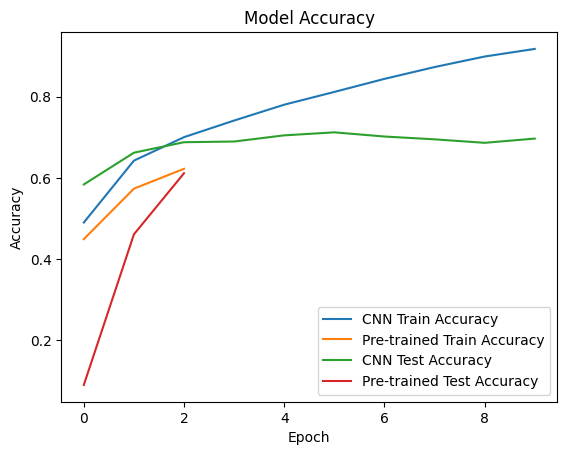

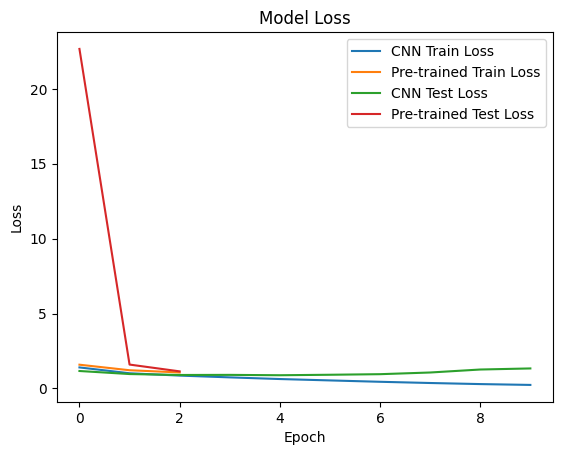

In [61]:
# Plot the train and test accuracy of the CNN and pre-trained models
plt.plot(cnn_history_true.history['accuracy'], label='CNN Train Accuracy')
plt.plot(pretrained_history.history['accuracy'], label='Pre-trained Train Accuracy')
plt.plot(cnn_history_true.history['val_accuracy'], label='CNN Test Accuracy')
plt.plot(pretrained_history.history['val_accuracy'], label='Pre-trained Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot the train and test loss of the CNN and pre-trained models
plt.plot(cnn_history_true.history['loss'], label='CNN Train Loss')
plt.plot(pretrained_history.history['loss'], label='Pre-trained Train Loss')
plt.plot(cnn_history_true.history['val_loss'], label='CNN Test Loss')
plt.plot(pretrained_history.history['val_loss'], label='Pre-trained Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

Extra test 1:
Changing number of units in the hidden layer.
First example has 64, second 128 units and third has 512. They both use Relu and two layers

In [ ]:
optimizer = GradientDescent(numOfHiddenLayers=2)
#128 units
mlp_128 =  MLP((Relu, Relu, Softmax,),numOfHiddenLayers=2,dimension=(3072,128,128,10))
fit_mlp_128, a_8 = mlp_128.fit(x_train,y_train, optimizer)
print("Accuracy on test data with 128 units in hidden layer", np.mean(fit_mlp_128.predict(x_test) == np.argmax(y_test,axis = 1)))
#512 units
mlp_512 =  MLP((Relu, Relu, Softmax,),numOfHiddenLayers=2,dimension=(3072,512,512,10))
fit_mlp_512, a_9 = mlp_512.fit(x_train,y_train, optimizer)
print("Accuracy on test data with 512 units in hidden layer", np.mean(fit_mlp_512.predict(x_test) == np.argmax(y_test,axis = 1)))

mlp_64 =  MLP((Relu, Relu, Softmax,),numOfHiddenLayers=2,dimension=(3072,64,64,10))
fit_mlp_64, a_10 = mlp_64.fit(x_train,y_train, optimizer)
print("Accuracy on test data with 64 units in hidden layer", np.mean(fit_mlp_64.predict(x_test) == np.argmax(y_test,axis = 1)))


Accuracy on test data with 128 units in hidden layer 0.4941
Accuracy on test data with 512 units in hidden layer 0.5115
Accuracy on test data with 64 units in hidden layer 0.4837


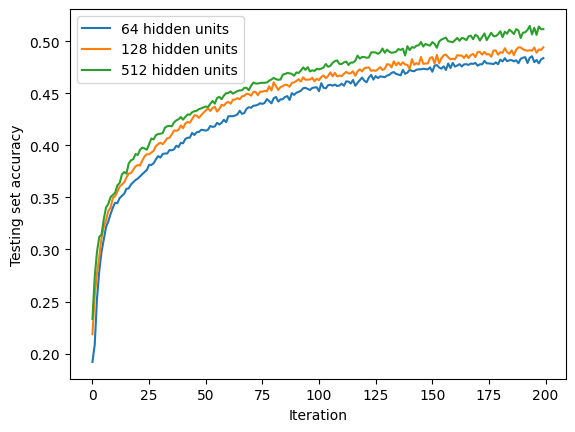

In [ ]:
# Create a line plot of the accuracies for each list
plt.plot(a_10, label='64 hidden units')
plt.plot(a_8, label='128 hidden units')
plt.plot(a_9, label='512 hidden units')

# Add labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Testing set accuracy')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

Increasing the depth of the model, 3 and 4 hidden layers

In [ ]:
optimizer = GradientDescent(numOfHiddenLayers=3)
#3 hidden
hidden_3 =  MLP((Relu, Relu, Relu,Softmax,),numOfHiddenLayers=3,dimension=(3072,128,128,128,10))
fit_hidden_3, a_11 = hidden_3.fit(x_train,y_train, optimizer)
print("Accuracy on test data with 128 units in hidden layer", np.mean(fit_hidden_3.predict(x_test) == np.argmax(y_test,axis = 1)))



Accuracy on test data with 128 units in hidden layer 0.5085
Accuracy on test data with 128 units in hidden layer 0.5005


In [ ]:
#4 hidden
optimizer = GradientDescent(numOfHiddenLayers=4)
hidden_4 =  MLP((Relu, Relu, Relu, Relu, Softmax,),numOfHiddenLayers=4,dimension=(3072,128,128,128,128,10))
fit_hidden_4, a_12 = hidden_4.fit(x_train,y_train, optimizer)
print("Accuracy on test data with 128 units in hidden layer", np.mean(fit_hidden_4.predict(x_test) == np.argmax(y_test,axis = 1)))

Accuracy on test data with 128 units in hidden layer 0.5095


In [49]:
#5 hidden
optimizer = GradientDescent(numOfHiddenLayers=5)
hidden_5 =  MLP((Relu, Relu, Relu, Relu, Relu, Softmax,),numOfHiddenLayers=5,dimension=(3072,128,128,128,128,128,10))
fit_hidden_5, a_13 = hidden_5.fit(x_train,y_train, optimizer)
print("Accuracy on test data with 128 units in hidden layer", np.mean(fit_hidden_5.predict(x_test) == np.argmax(y_test,axis = 1)))

Accuracy on test data with 128 units in hidden layer 0.5065


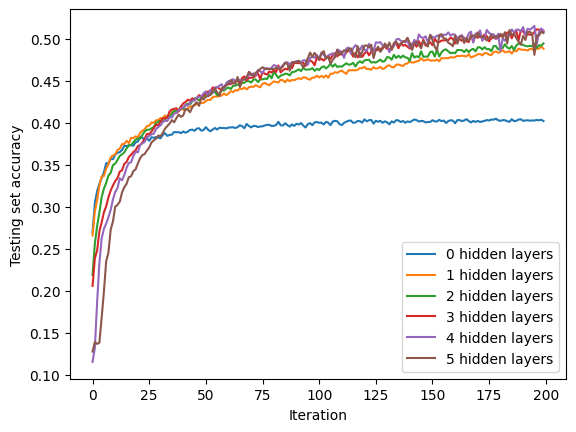

In [55]:
# Create a line plot of the accuracies for each list
plt.plot(a_0, label='0 hidden layers')
plt.plot(a_1, label='1 hidden layers')
plt.plot(a_8, label='2 hidden layers')
plt.plot(a_11, label='3 hidden layers')
plt.plot(a_12, label='4 hidden layers')
plt.plot(a_13, label='5 hidden layers')
# Add labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Testing set accuracy')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()